In [1]:
from chromatic_fitting import *
from src.inject_spectrum import generate_spectrum_ld
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal, InverseGamma, Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup, estimate_inverse_gamma_parameters
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


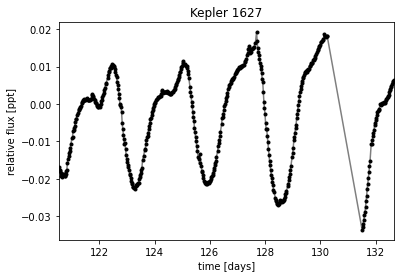

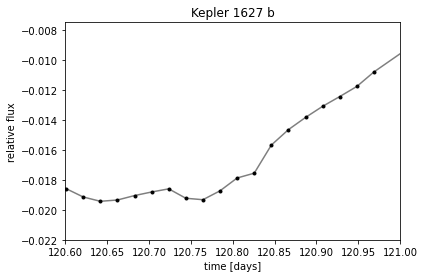

In [2]:
import lightkurve as lk
# Get long cadence light curves for all quarters. Median normalize all
# quarters, remove nans, and run a 5-sigma outlier clipping.
lcf = lk.search_lightcurve(
    "6184894", mission="Kepler", author="Kepler", cadence="long"
).download_all()
lc = lcf.stitch().remove_nans().remove_outliers()

# Require non-zero quality flags, since we have an abundance of data.
lc = lc[lc.quality == 0]
lc = lc[:500]

# Make sure that the data type is consistent
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))

# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu

# Visualize the data.
# Plot #0: full dataset
# Plot #1: a 100 day slice
# Plot #2: center it on the known Kepler ephemeris.
plt.plot(x, y, "k", alpha=0.5)
plt.plot(x, y, "k.")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("Kepler 1627")
plt.show()

# plt.plot(x, y, "k")
# plt.xlabel("time [days]")
# plt.ylabel("relative flux [ppt]")
# plt.xlim([550, 650])
# plt.title("Kepler 1627")
# plt.show()

plt.plot(x, y, "k",alpha=0.5)
plt.plot(x, y, "k.")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([120.6, 121])  # transit is here
plt.ylim([-22e-3, -7.5e-3])
plt.title("Kepler 1627 b")
plt.show()

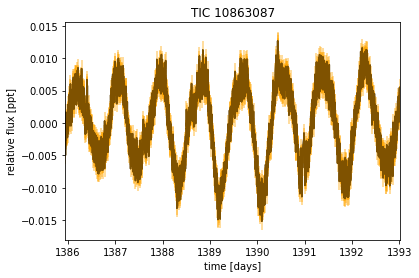

In [24]:
import lightkurve as lk

lcf = lk.search_lightcurve(
    "TIC 10863087", mission="TESS", author="SPOC"
).download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lcf.stitch().remove_nans().remove_outliers()
lc = lc[:5000]
_, mask = lc.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc = lc[~mask]

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) #* 1e3
yerr = yerr / mu #* 1e3 / mu

plt.errorbar(x, y, yerr, color="orange", alpha=0.5)
plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087")


🌈 Warning: 
The time scale for this rainbow is '?',
and there are 500 time centers and
0 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).


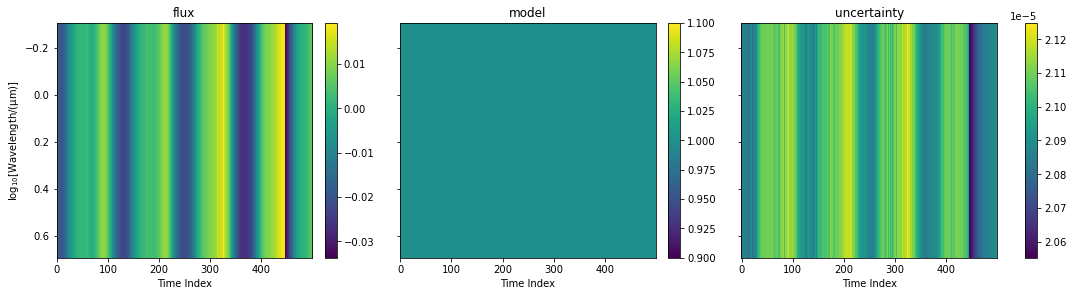

In [3]:
# s = Rainbow(dict_to_rainbow)
s = SimulatedRainbow(time=x*u.day, R=50)
s.fluxlike['flux'][:,:] = y
s.fluxlike['uncertainty'][:,:] = yerr
s = s.bin(nwavelengths=int(s.nwave/5))#, dt=5 * u.minute)
s.imshow_quantities();

In [4]:
print(np.mean(s.uncertainty),np.std(s.flux))

2.099524501518174e-05 0.012400417617093479


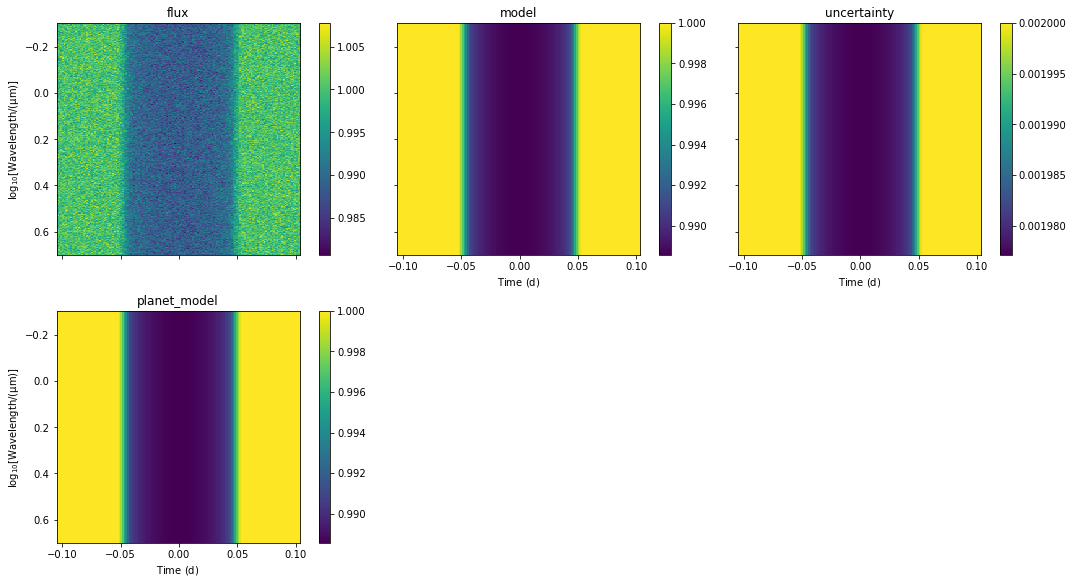

In [68]:
s = SimulatedRainbow().inject_transit().inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [5]:
# set up GP model:
# gp = SHO_Model()
gp = QuasiPeriodicModel()
gp.initialize_empty_model()

# gp.setup_parameters(
# #      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
#                 log_sigma=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(1.0, 5.0)),
#                 log_rho=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(0.5, 2.0)),
#                 Q = Fitted(Normal, mu=1.0/np.sqrt(2.0)),
#                 log_jitter = Fitted(Normal,mu=np.log(np.mean(s.uncertainty)),sigma=2.0),
#                 mean = 1.0
#                 )
# A jitter term describing excess white noise
# A term to describe the non-periodic variability

gp.setup_parameters(
        # Rotation period is 2.6 days, from Lomb Scargle
        log_period = Fitted(Normal, mu=np.log(2.606418), sd=0.02),
        log_sigma=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(1.0, 5.0)),
        log_Q = Fitted(Normal, mu=0, sd=2),
        log_d = Fitted(Normal, mu=0, sd=2),
        f = Fitted(Uniform, lower=0.01, upper=1),
        log_jitter = Fitted(Normal,mu=np.log(np.mean(s.uncertainty)),sigma=2.0),
        mean=0.0
)
gp.summarize_parameters()

# set up transit model:
t = TransitModel()
t.initialize_empty_model()

        
t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=Fitted(Normal, mu=7.203,sigma=0.01),
                   epoch=Fitted(Normal,mu=120.79,sigma=0.02),
                   stellar_radius = Fitted(Normal, mu=0.881, sigma=0.018),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.04, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 0.0 #Fitted(Uniform, lower=0.95,upper=1.05)
                )
t.summarize_parameters()

gp_log_sigma =
  <🧮 Fitted InverseGamma(alpha=8.919240823724936, beta=17.290248729724535, name='log_sigma') 🧮>

gp_log_period =
  <🧮 Fitted Normal(mu=0.9579768649191449, sd=0.02, name='log_period') 🧮>

gp_log_d =
  <🧮 Fitted Normal(mu=0, sd=2, name='log_d') 🧮>

gp_log_Q =
  <🧮 Fitted Normal(mu=0, sd=2, name='log_Q') 🧮>

gp_f =
  <🧮 Fitted Uniform(lower=0.01, upper=1, name='f') 🧮>

gp_log_jitter =
  <🧮 Fitted Normal(mu=-10.771214573727995, sigma=2.0, name='log_jitter') 🧮>

gp_mean =
  <🧮 Fixed | 0.0 🧮>

transit_stellar_radius =
  <🧮 Fitted Normal(mu=0.881, sigma=0.018, name='stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.04, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fitted Normal(mu=7.203, sigma=0.01, name='period') 🧮>

transit_epoch =
  <🧮 Fitted Normal(mu=120.79, sigma=0.02, name='epoch') 🧮>

transit_baseline =
  <🧮 Fixe

In [6]:
cm = gp + t

In [7]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17863.30it/s]


In [8]:
opt = cm.optimize()
# cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
# cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, transit_period, gp_log_jitter, gp_f, gp_log_d, gp_log_Q, gp_log_period, gp_log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 3072.1072821484677 -> 12105.223816642218


In [9]:
opt

{'gp_log_sigma_log__': array(-1.88589761),
 'gp_log_period': array(-0.22091773),
 'gp_log_Q': array(9.28409601),
 'gp_log_d': array(0.58402676),
 'gp_f_interval__': array(-3.09464909),
 'gp_log_jitter': array(-18.81594601),
 'transit_period': array(7.10903132),
 'transit_epoch': array(120.55897293),
 'transit_impact_parameter_impact__': array(-0.47089804),
 'transit_stellar_radius': array(0.86032193),
 'transit_stellar_mass_interval__': array(0.00084264),
 'transit_limb_darkening_quadlimbdark__': array([-1.6472907 , -2.69440311]),
 'transit_radius_ratio_w0': array(0.01979532),
 'transit_radius_ratio_w1': array(0.01979532),
 'transit_radius_ratio_w2': array(0.01979532),
 'transit_radius_ratio_w3': array(0.01979532),
 'transit_radius_ratio_w4': array(0.01979532),
 'gp_log_sigma': array(0.15169284),
 'gp_f': array(0.05289523),
 'transit_impact_parameter': array(0.44206427),
 'transit_stellar_mass': array(1.00008426),
 'transit_limb_darkening': array([0.05087651, 0.35096358])}

In [10]:
ç = cm.chromatic_models['transit'].transit_model(opt)

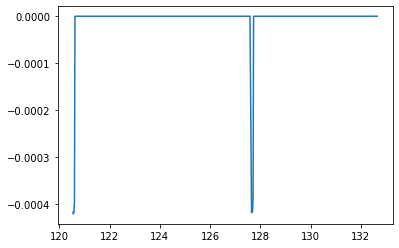

In [13]:
plt.plot(cm.data.time,ytransit[0])

In [14]:
with cm.pymc3_model:
    ygp = eval_in_model(cm.gp.predict(y=cm.data.flux[0, :]-ytransit[0]))
#     ypred = eval_in_model(cm.gp.predict(y=cm.data.flux[0, :]))

In [15]:
ygp

array([-1.65691415e-02, -1.72706179e-02, -1.76203108e-02, -1.82039963e-02,
       -1.91410846e-02, -1.94334076e-02, -1.93453370e-02, -1.90522577e-02,
       -1.88088744e-02, -1.86073476e-02, -1.92262252e-02, -1.93270945e-02,
       -1.87308298e-02, -1.78856338e-02, -1.75460751e-02, -1.56904306e-02,
       -1.46503437e-02, -1.38394701e-02, -1.30980382e-02, -1.24481477e-02,
       -1.17717972e-02, -1.08042016e-02, -9.22466110e-03, -8.75759289e-03,
       -7.18660775e-03, -6.96807954e-03, -6.35494121e-03, -5.83783900e-03,
       -4.84592562e-03, -4.06799932e-03, -3.93405568e-03, -2.90788986e-03,
       -2.48447101e-03, -1.59197346e-03, -1.37506639e-03, -1.08939701e-03,
       -9.12506616e-04, -4.36749793e-04,  2.72659576e-04,  4.61323380e-04,
        8.61247821e-04,  1.04184811e-03,  1.15868905e-03,  1.40208793e-03,
        1.19944480e-03,  1.15815197e-03,  1.46704908e-03,  1.58839743e-03,
        1.29430517e-03,  9.50781842e-04,  1.14360764e-03,  1.19446547e-03,
        1.05328255e-03,  

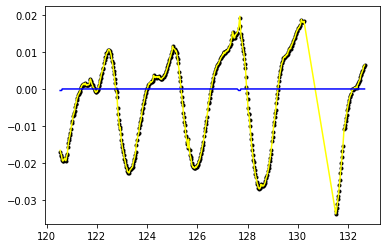

In [18]:
plt.plot(cm.data.time, cm.data.flux[0,:],'k.')
plt.plot(cm.data.time, ygp, color='yellow')
plt.plot(cm.data.time, ytransit[0], color='blue')

In [26]:
gp.trace[0]

{'log_sigma_log__': -1.6883580182589506,
 'log_period': 1.6479717034911767,
 'log_Q': 7.3754153033648,
 'log_d': -1.7484309712977715,
 'f_interval__': -8.783618934736436,
 'log_jitter': -16.349725748121866,
 'log_sigma': 0.18482275056036887,
 'f': 0.010151667113515355}

In [47]:
import matplotlib as mpl
def plot_light_curve(x, y, mod, gp_mod, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=5.0,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
#     gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=41, lw=0.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp", alpha=0.2)
    ax.plot(x[mask], y[mask] - gp_mod, "k.")
#     for i, l in enumerate("b"):
#         mod = soln["transit_pred"][:, i]
    ax.plot(
            x[mask],
            mod,
            label="transit model",
            zorder=-10,
        ) 
#    label="planet {0} [model under]".format(l),
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
#     for i, l in enumerate("b"):
#         mod = soln["transit_pred"][:, i]
    ax.plot(x[mask], mod, label="transit model") # {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

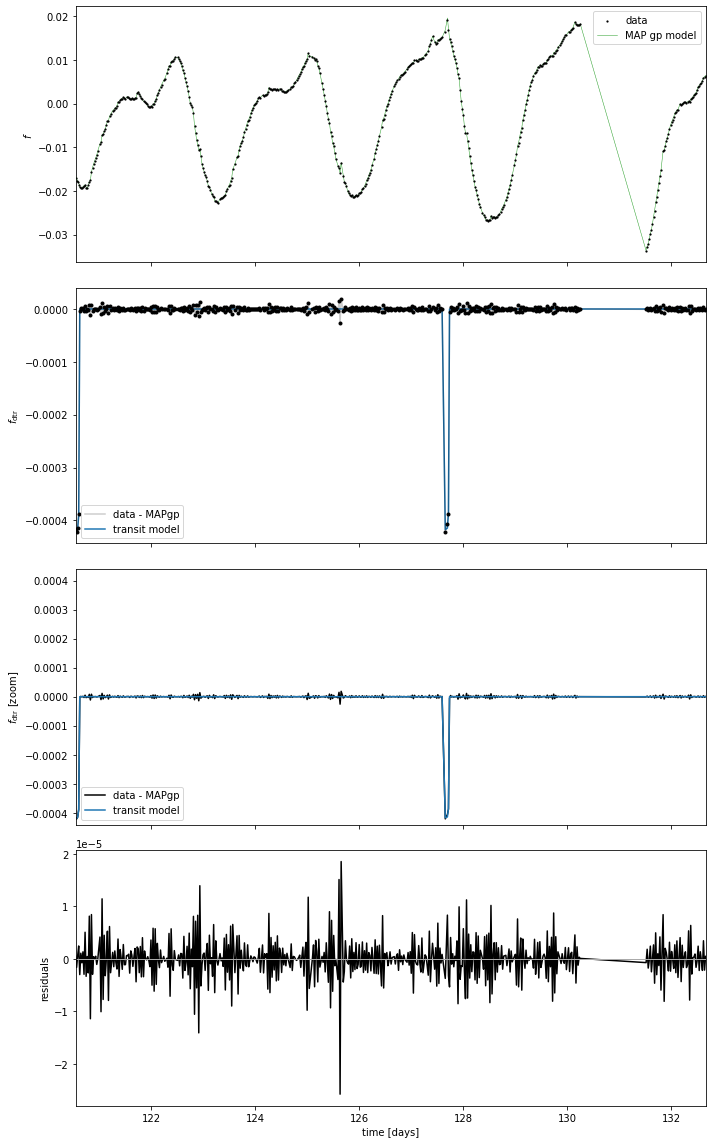

In [48]:
plot_light_curve(cm.data.time.to_value("day"), cm.data.flux[0,:], ytransit[0], ygp, opt)

In [ ]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))
x = cm.data.time
y = cm.data.flux

# Ephemeris from Holczer+16
t0 = 120.790531
period = 7.20280608

x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - opt["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.2,
    linewidths=0,
)

lc_mod = opt["transit_pred"][:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + opt["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - opt["gp_pred"])
denom[num == 0] = 1.0
ax.scatter(
    0.5 * (bins[1:] + bins[:-1]),
    1e3 * num / denom,
    color="C1",
    zorder=2,
    linewidths=0,
)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-3, 0.5)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscr


🌈 Warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

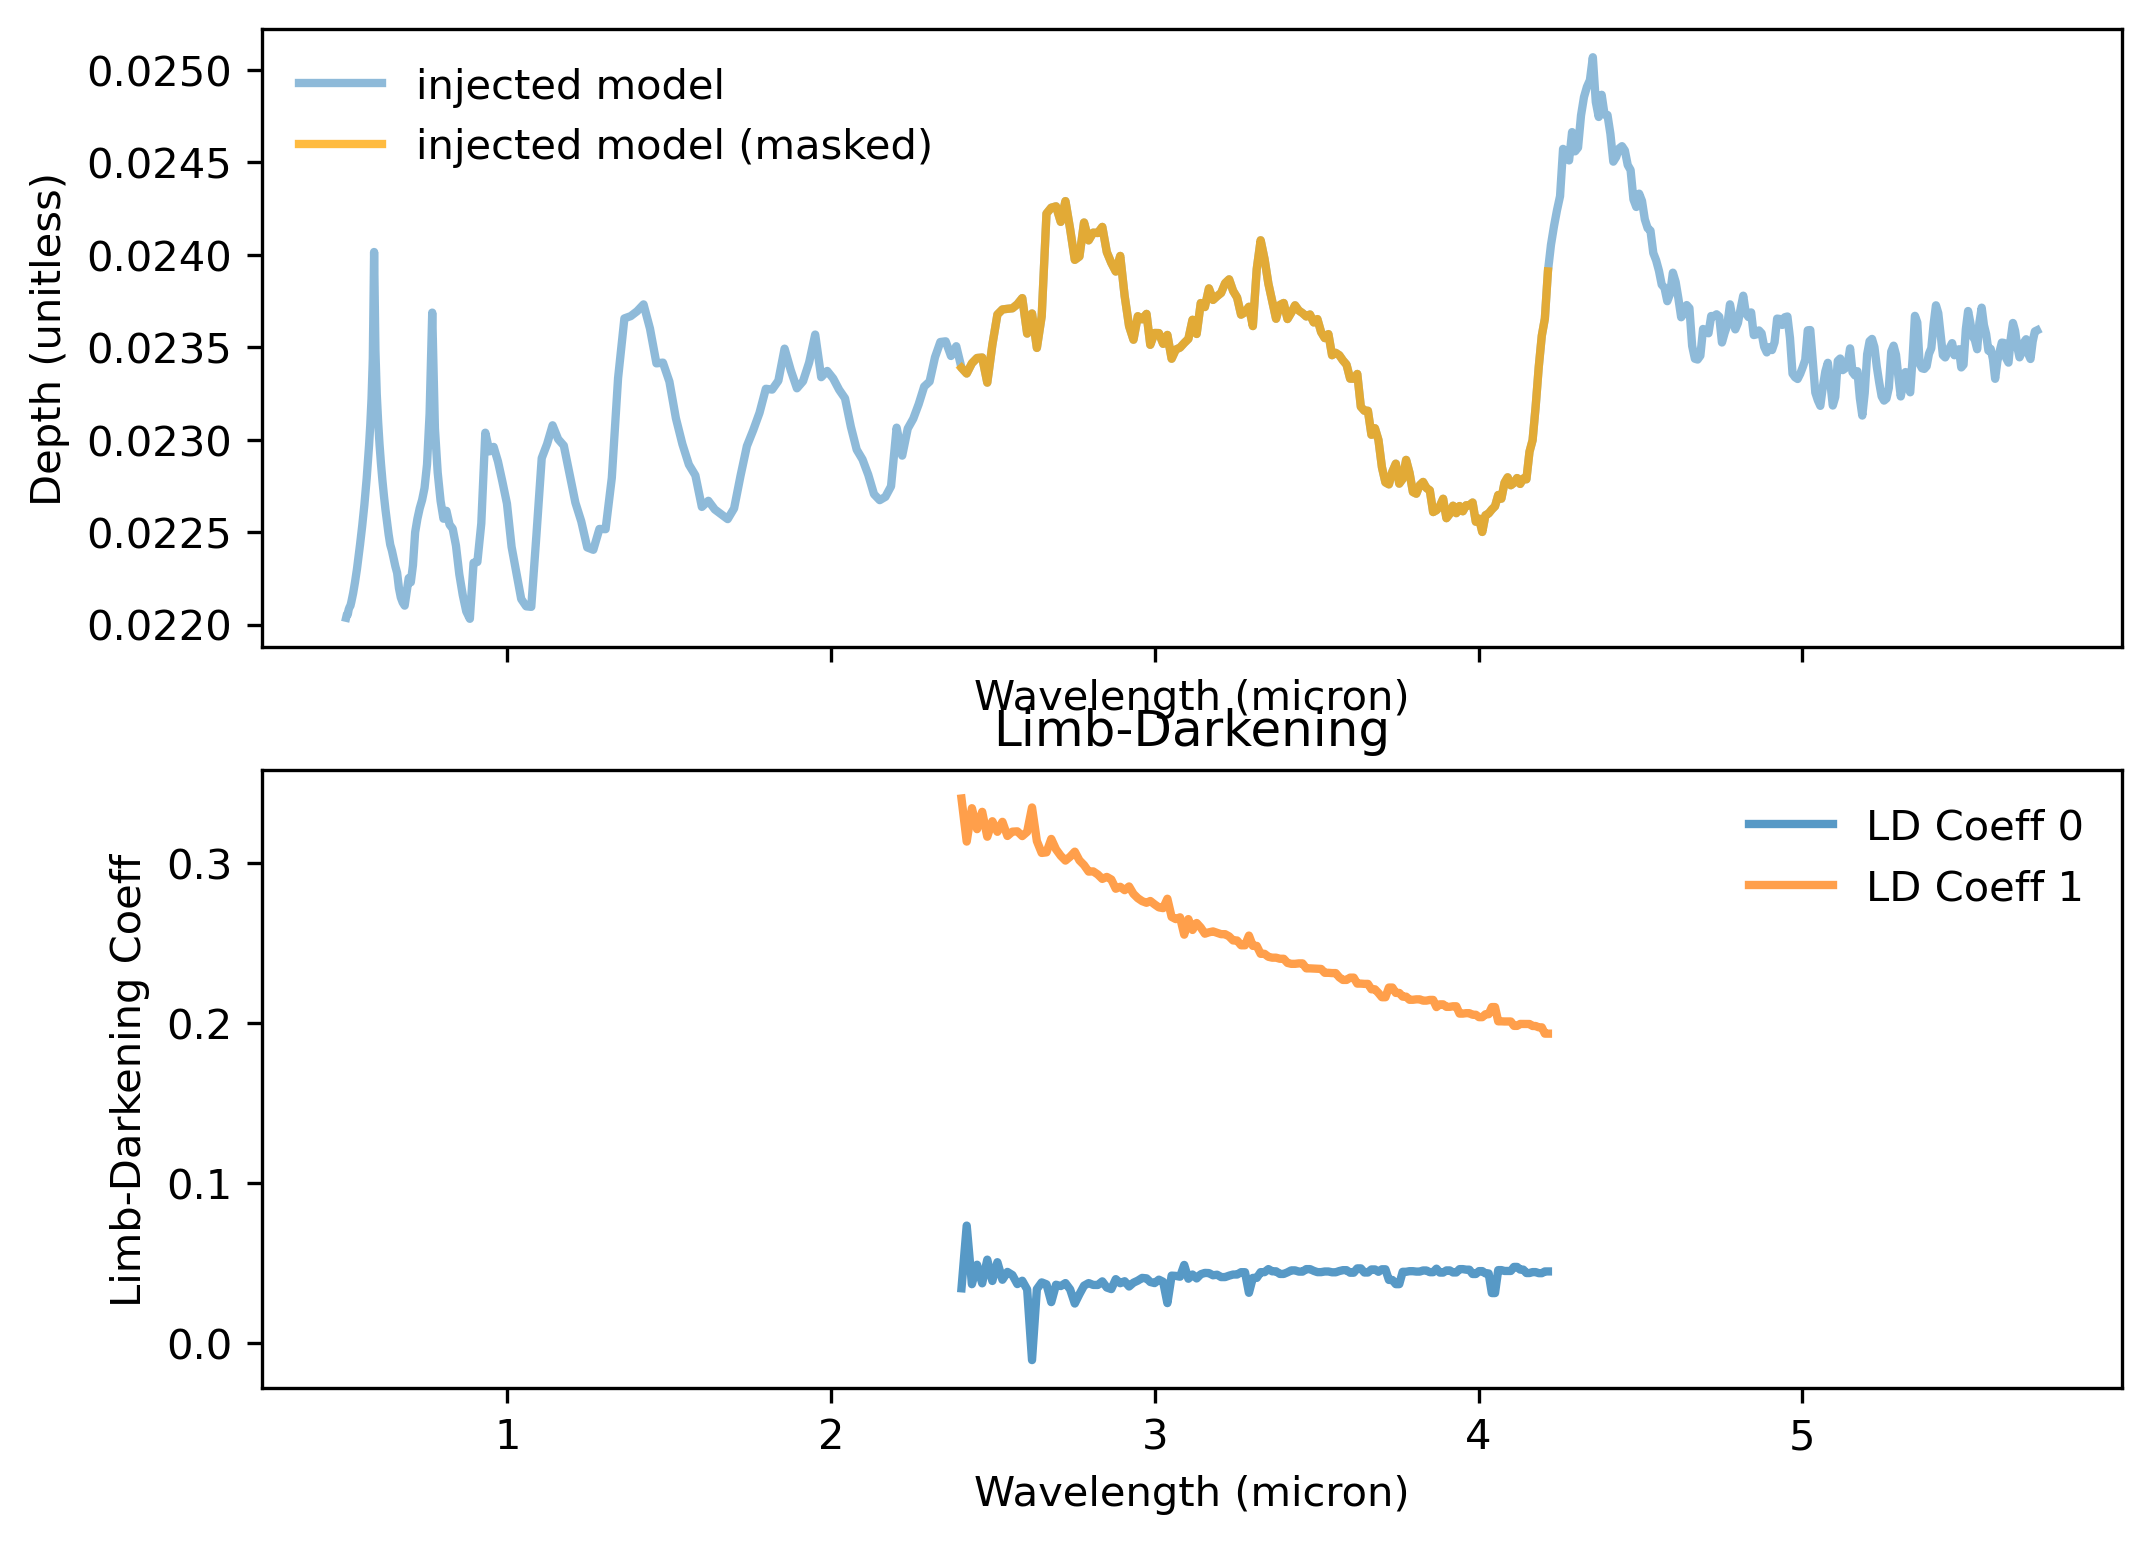

In [4]:
star_params = {"M_H": -0.03,
                   "Teff": 5326.6, 
                   "logg": 4.38933,
                   "r_s" : 0.895,
                   "m_s" : 0.93,
                  }

injplanet_params = {
                "t0": 0,
                "per": 4.055259, # orbital period (days), Faedi et al. 2011
                "a": 11.37, # semi-major axis (stellar radii)
                "inc": 87.83, # inclination (degrees), Faedi et al. 2011
                "ecc": 0,
                "w": 0
            }

# load Patricio's spectrum model:
model_staticld, planet_params, wavelength,transmission = import_patricio_model("data_challenge_spectra_v01.pickle")

# add LD coeffs:
#  define where the zenodo LD files are stored (needed for ExoTiC)
dirsen = '/Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data_old'
#  calculate the LD coeffs for a series of wavelengths and transit depths
model_ld = generate_spectrum_ld(wavelength, transmission, star_params, planet_params, dirsen, mode="JWST_NIRCam_F322W2",
                                    ld_eqn="quadratic", ld_model='1D', plot_model=True)

In [7]:
model_ld.ld_coeffs

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       array([0.03434394, 0.34056823]), array([0.07353399, 0.31364434]),
       array([0.03690275, 0.33451489]), array([0.04907525, 0.32